In [3]:
# Import required libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Libraries loaded!")

Libraries loaded!


## 1. Load Pre-computed Data

In [4]:
# Load data with pre-computed topics and sentiment
data = []
with open('data_with_topics_sentiment_v2.jsonl', 'r') as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)
print(f"✅ Loaded {len(df)} posts with topics and sentiment")

# Convert embeddings to numpy array
embeddings = np.array(df['embedding'].tolist())
print(f"Embedding shape: {embeddings.shape}")

# Extract topic words from topic_label (format: "id_word1_word2_word3_word4")
def extract_topic_words(label):
    parts = label.split('_')
    if len(parts) > 1:
        return parts[1:]  # Skip the ID part
    return []

df['topic_words'] = df['topic_label'].apply(extract_topic_words)

# Quick overview
print(f"\n📊 Data Overview:")
print(f"   • Topics: {df['topic_id'].nunique()} unique topics")
print(f"   • Sentiments: {df['sentiment_label'].value_counts().to_dict()}")

✅ Loaded 8799 posts with topics and sentiment
Embedding shape: (8799, 1024)

📊 Data Overview:
   • Topics: 48 unique topics
   • Sentiments: {'neutral': 5411, 'negative': 2787, 'positive': 601}


## 2. Topic Analysis (BERTopic Results)

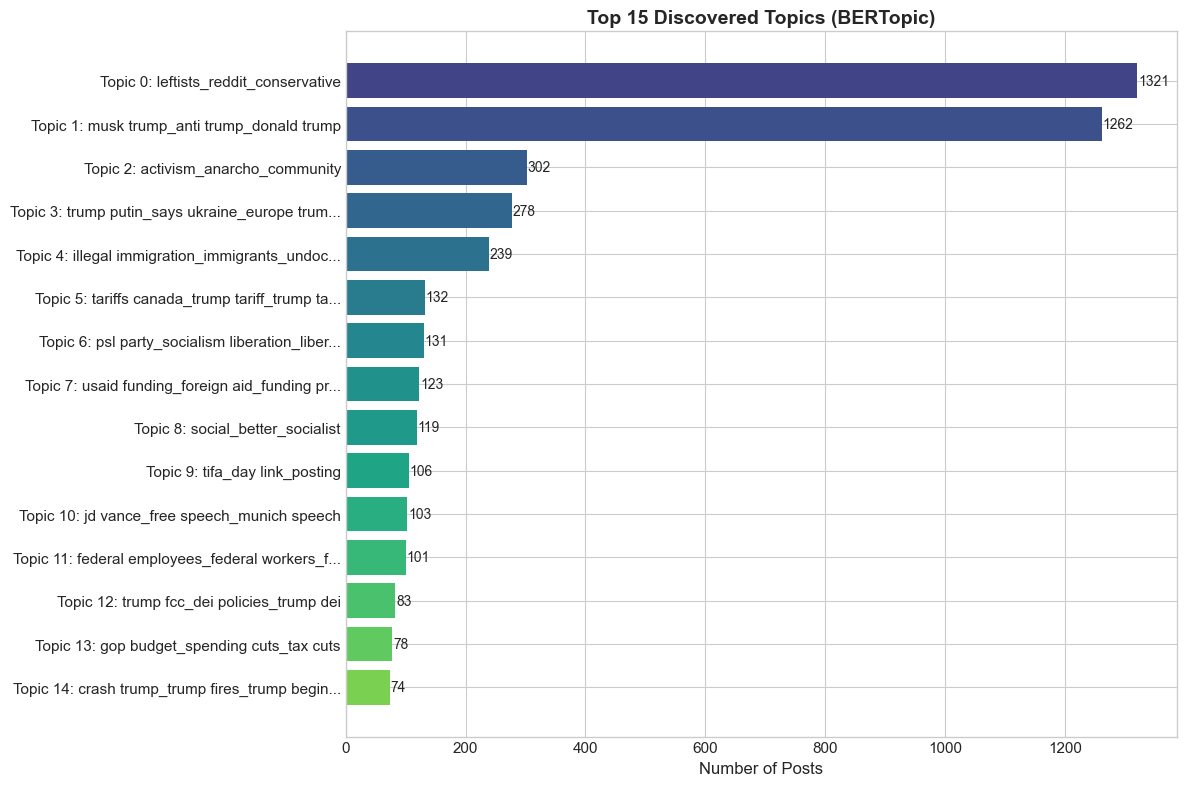

In [5]:
# Topic distribution
topic_counts = df[df['topic_id'] != -1]['topic_id'].value_counts().head(15)

fig, ax = plt.subplots(figsize=(12, 8))

# Get topic labels - extract readable name from topic_label
topic_labels = []
for tid in topic_counts.index:
    label = df[df['topic_id'] == tid]['topic_label'].iloc[0]
    # Format: "id_word1_word2_..." -> "Topic id: word1, word2, ..."
    words = '_'.join(label.split('_')[1:4])  # Get first 3 keywords
    display_label = f"Topic {tid}: {words}"
    display_label = display_label[:45] + '...' if len(display_label) > 45 else display_label
    topic_labels.append(display_label)

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(topic_counts)))
ax.barh(topic_labels, topic_counts.values, color=colors)
ax.set_xlabel('Number of Posts', fontsize=12)
ax.set_title('Top 15 Discovered Topics (BERTopic)', fontsize=14, fontweight='bold')
ax.invert_yaxis()

for i, v in enumerate(topic_counts.values):
    ax.text(v + 1, i, str(v), va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [6]:
# Topic details with keywords
print("="*80)
print("                    DISCOVERED TOPICS & KEYWORDS")
print("="*80)

for topic_id in topic_counts.index[:10]:
    topic_df = df[df['topic_id'] == topic_id]
    topic_label = topic_df['topic_label'].iloc[0]
    # Extract keywords from topic_label (format: "id_word1_word2_word3_word4")
    topic_words = topic_df['topic_words'].iloc[0][:8] if len(topic_df['topic_words'].iloc[0]) > 0 else []
    avg_sentiment = topic_df['sentiment_score'].mean()
    
    sentiment_emoji = "😊" if avg_sentiment > 0.1 else "😠" if avg_sentiment < -0.1 else "😐"
    
    # Create a cleaner display label
    display_label = ' '.join(topic_words[:4]) if topic_words else topic_label
    
    print(f"\n📌 Topic {topic_id}: {display_label}")
    print(f"   Posts: {len(topic_df)} | Avg Sentiment: {avg_sentiment:.2f} {sentiment_emoji}")
    print(f"   Keywords: {', '.join(topic_words)}")

                    DISCOVERED TOPICS & KEYWORDS

📌 Topic 0: leftists reddit conservative wanna
   Posts: 1321 | Avg Sentiment: -0.07 😐
   Keywords: leftists, reddit, conservative, wanna

📌 Topic 1: musk trump anti trump donald trump trump
   Posts: 1262 | Avg Sentiment: -0.29 😠
   Keywords: musk trump, anti trump, donald trump, trump

📌 Topic 2: activism anarcho community libertarian
   Posts: 302 | Avg Sentiment: -0.07 😐
   Keywords: activism, anarcho, community, libertarian

📌 Topic 3: trump putin says ukraine europe trump trump
   Posts: 278 | Avg Sentiment: -0.23 😠
   Keywords: trump putin, says ukraine, europe trump, trump

📌 Topic 4: illegal immigration immigrants undocumented immigrants immigration
   Posts: 239 | Avg Sentiment: -0.39 😠
   Keywords: illegal immigration, immigrants, undocumented immigrants, immigration

📌 Topic 5: tariffs canada trump tariff trump tariffs trump trade
   Posts: 132 | Avg Sentiment: -0.23 😠
   Keywords: tariffs canada, trump tariff, trump tariffs,

## 3. Sentiment Analysis (RoBERTa Results)

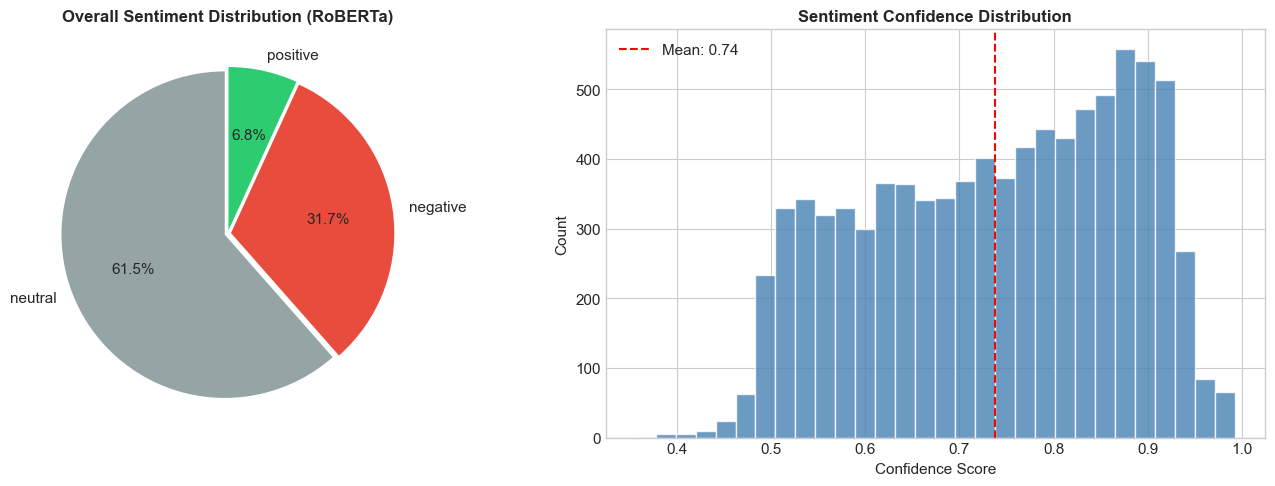

In [7]:
# Sentiment distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
sentiment_counts = df['sentiment_label'].value_counts()
colors_map = {'positive': '#2ecc71', 'neutral': '#95a5a6', 'negative': '#e74c3c'}
colors = [colors_map.get(s, '#3498db') for s in sentiment_counts.index]

axes[0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90, explode=[0.02]*len(sentiment_counts))
axes[0].set_title('Overall Sentiment Distribution (RoBERTa)', fontsize=12, fontweight='bold')

# Confidence histogram
axes[1].hist(df['sentiment_confidence'], bins=30, color='steelblue', edgecolor='white', alpha=0.8)
axes[1].axvline(df['sentiment_confidence'].mean(), color='red', linestyle='--', label=f"Mean: {df['sentiment_confidence'].mean():.2f}")
axes[1].set_xlabel('Confidence Score', fontsize=11)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].set_title('Sentiment Confidence Distribution', fontsize=12, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

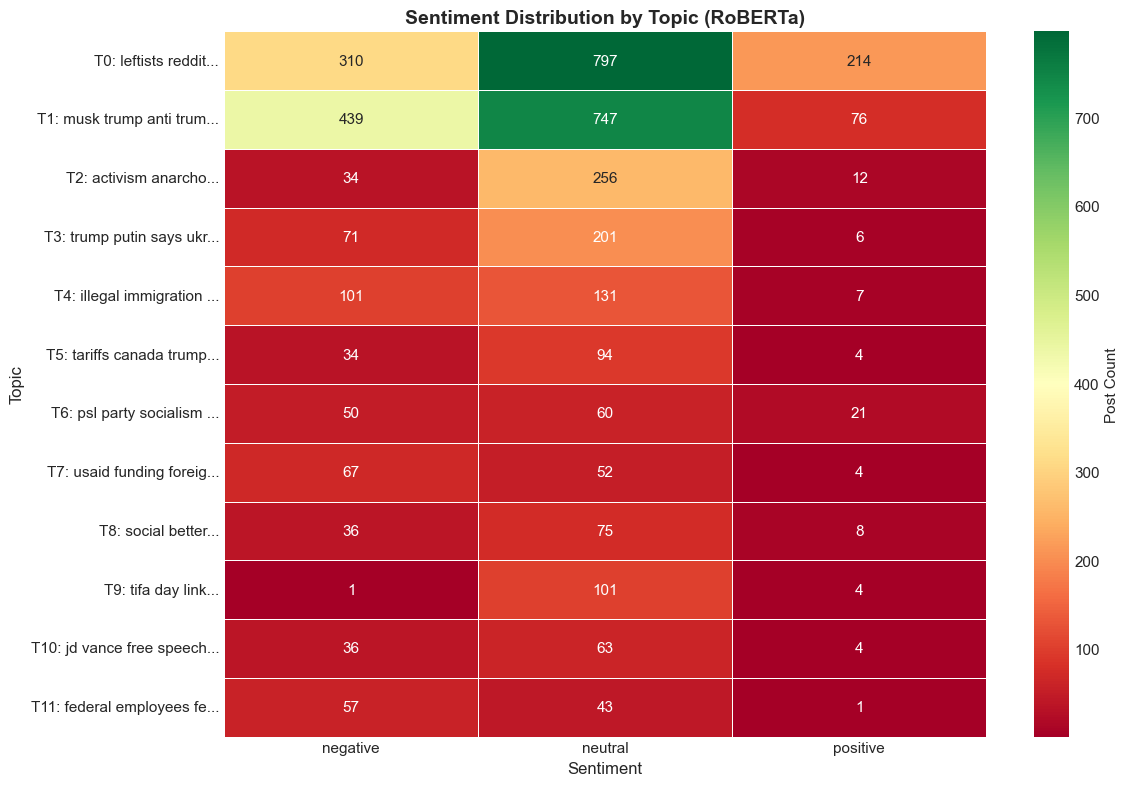

In [8]:
# Sentiment by topic heatmap
# Filter to top topics
top_topics = df[df['topic_id'] != -1]['topic_id'].value_counts().head(12).index.tolist()
df_filtered = df[df['topic_id'].isin(top_topics)]

sentiment_pivot = df_filtered.groupby(['topic_id', 'sentiment_label']).size().unstack(fill_value=0)

# Add topic labels - extract keywords from topic_label
topic_label_map = {}
for tid in sentiment_pivot.index:
    label = df[df['topic_id'] == tid]['topic_label'].iloc[0]
    words = ' '.join(label.split('_')[1:3])  # Get first 2 keywords
    topic_label_map[tid] = words

sentiment_pivot.index = [f"T{tid}: {topic_label_map.get(tid, '')[:20]}..." for tid in sentiment_pivot.index]

plt.figure(figsize=(12, 8))
sns.heatmap(sentiment_pivot, annot=True, fmt='d', cmap='RdYlGn', linewidths=0.5,
            cbar_kws={'label': 'Post Count'})
plt.title('Sentiment Distribution by Topic (RoBERTa)', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Topic', fontsize=12)
plt.tight_layout()
plt.show()

## 4. Cluster Visualization (t-SNE)

In [9]:
# Reduce dimensions for visualization
print("Computing t-SNE projection...")

# PCA first for speed
pca = PCA(n_components=50, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings_pca)

df['tsne_x'] = embeddings_2d[:, 0]
df['tsne_y'] = embeddings_2d[:, 1]

print("✅ t-SNE complete!")

Computing t-SNE projection...
✅ t-SNE complete!


In [10]:
# Interactive plot with Plotly - colored by topic
df_plot = df[df['topic_id'] != -1].copy()  # Exclude outliers
df_plot['topic_str'] = 'Topic ' + df_plot['topic_id'].astype(str)

fig = px.scatter(
    df_plot,
    x='tsne_x',
    y='tsne_y',
    color='topic_str',
    hover_data=['title', 'sentiment_label', 'score'],
    title='Posts Clustered by Topic (t-SNE Visualization)',
    labels={'tsne_x': 't-SNE 1', 'tsne_y': 't-SNE 2'},
    opacity=0.7
)
fig.update_layout(height=700, width=1000)
fig.show()

In [11]:
# Plot colored by sentiment
color_map = {'positive': 'green', 'neutral': 'gray', 'negative': 'red'}

fig = px.scatter(
    df,
    x='tsne_x',
    y='tsne_y',
    color='sentiment_label',
    color_discrete_map=color_map,
    hover_data=['title', 'topic_label', 'score'],
    title='Posts Colored by Sentiment (RoBERTa)',
    labels={'tsne_x': 't-SNE 1', 'tsne_y': 't-SNE 2'},
    opacity=0.6
)
fig.update_layout(height=700, width=1000)
fig.show()

## 5. Engagement Analysis

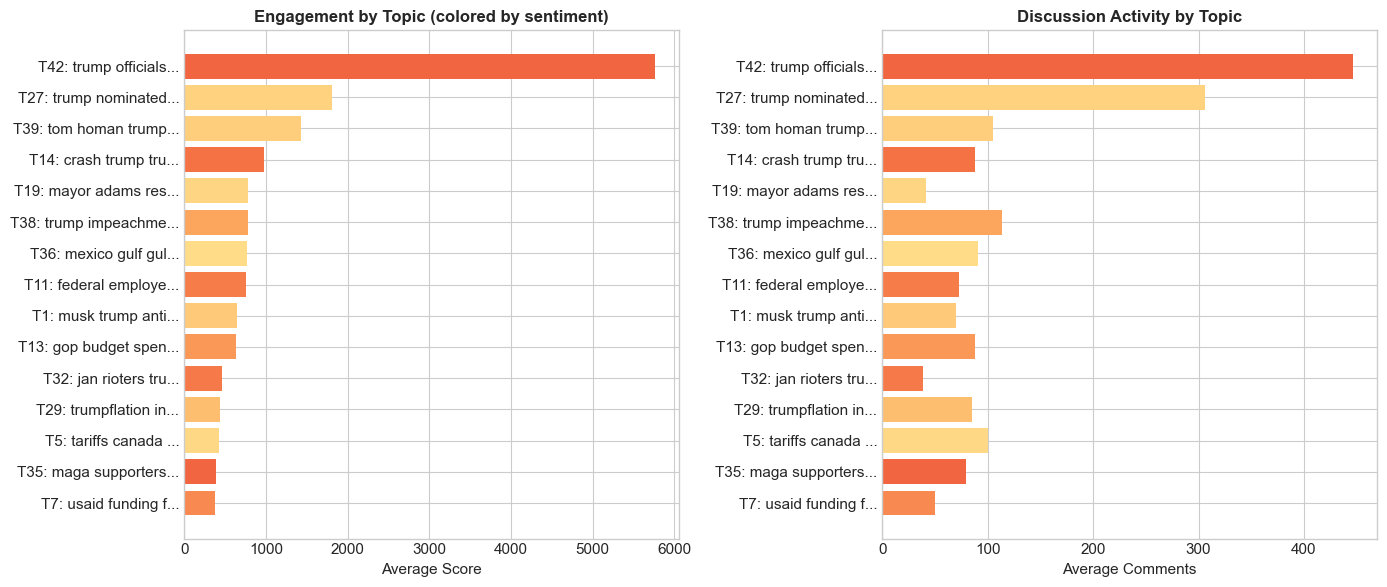

In [12]:
# Engagement by topic
topic_engagement = df[df['topic_id'] != -1].groupby('topic_id').agg({
    'score': 'mean',
    'num_comments': 'mean',
    'title': 'count',
    'topic_label': 'first',
    'sentiment_score': 'mean'
}).rename(columns={'title': 'post_count'}).reset_index()

# Extract keywords for display
topic_engagement['display_label'] = topic_engagement['topic_label'].apply(
    lambda x: ' '.join(x.split('_')[1:3])
)

topic_engagement = topic_engagement.sort_values('score', ascending=False).head(15)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Score by topic
labels = [f"T{row['topic_id']}: {row['display_label'][:15]}..." for _, row in topic_engagement.iterrows()]
colors = plt.cm.RdYlGn((topic_engagement['sentiment_score'] + 1) / 2)  # Map sentiment to color

axes[0].barh(labels, topic_engagement['score'], color=colors)
axes[0].set_xlabel('Average Score', fontsize=11)
axes[0].set_title('Engagement by Topic (colored by sentiment)', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()

# Comments by topic
axes[1].barh(labels, topic_engagement['num_comments'], color=colors)
axes[1].set_xlabel('Average Comments', fontsize=11)
axes[1].set_title('Discussion Activity by Topic', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [13]:
# Sentiment vs Engagement scatter
fig = px.scatter(
    topic_engagement,
    x='sentiment_score',
    y='score',
    size='post_count',
    color='num_comments',
    hover_name='display_label',
    title='Topic Sentiment vs Engagement',
    labels={
        'sentiment_score': 'Average Sentiment (-1 to 1)',
        'score': 'Average Score',
        'num_comments': 'Avg Comments'
    },
    color_continuous_scale='Viridis'
)
fig.add_vline(x=0, line_dash="dash", line_color="gray")
fig.update_layout(height=600, width=900)
fig.show()

## 6. 🗳️ Political Insights Summary

In [14]:
print("\n" + "="*80)
print("           🗳️  KEY VOTER INSIGHTS (SOTA ANALYSIS)  🗳️")
print("="*80)

# Overall sentiment
sentiment_dist = df['sentiment_label'].value_counts(normalize=True)
avg_sentiment = df['sentiment_score'].mean()

print("\n📊 OVERALL SENTIMENT (RoBERTa Analysis):")
print(f"   • Positive: {sentiment_dist.get('positive', 0)*100:.1f}%")
print(f"   • Neutral:  {sentiment_dist.get('neutral', 0)*100:.1f}%")
print(f"   • Negative: {sentiment_dist.get('negative', 0)*100:.1f}%")
print(f"   • Net Sentiment Score: {avg_sentiment:.3f} {'✅' if avg_sentiment > 0 else '⚠️'}")

# Top topics
print("\n📌 TOP DISCUSSION TOPICS (BERTopic Discovery):")
top_5_topics = df[df['topic_id'] != -1]['topic_id'].value_counts().head(5)
for i, (tid, count) in enumerate(top_5_topics.items(), 1):
    label = df[df['topic_id'] == tid]['topic_label'].iloc[0]
    # Extract keywords from label
    keywords = ' '.join(label.split('_')[1:4])
    sentiment = df[df['topic_id'] == tid]['sentiment_score'].mean()
    emoji = "😊" if sentiment > 0.1 else "😠" if sentiment < -0.1 else "😐"
    print(f"   {i}. {keywords}... ({count} posts) {emoji}")


           🗳️  KEY VOTER INSIGHTS (SOTA ANALYSIS)  🗳️

📊 OVERALL SENTIMENT (RoBERTa Analysis):
   • Positive: 6.8%
   • Neutral:  61.5%
   • Negative: 31.7%
   • Net Sentiment Score: -0.248 ⚠️

📌 TOP DISCUSSION TOPICS (BERTopic Discovery):
   1. leftists reddit conservative... (1321 posts) 😐
   2. musk trump anti trump donald trump... (1262 posts) 😠
   3. activism anarcho community... (302 posts) 😐
   4. trump putin says ukraine europe trump... (278 posts) 😠
   5. illegal immigration immigrants undocumented immigrants... (239 posts) 😠


In [15]:
# Most engaging topics
print("\n📈 HIGHEST ENGAGEMENT TOPICS:")
high_engagement = topic_engagement.nlargest(5, 'score')
for i, (_, row) in enumerate(high_engagement.iterrows(), 1):
    print(f"   {i}. {row['display_label']}...")
    print(f"      Score: {row['score']:.1f} | Comments: {row['num_comments']:.1f}")

# Most negative topics (areas of concern)
print("\n⚠️ AREAS OF VOTER FRUSTRATION (Most Negative):")
negative_topics = topic_engagement.nsmallest(5, 'sentiment_score')
for i, (_, row) in enumerate(negative_topics.iterrows(), 1):
    print(f"   {i}. {row['display_label']}...")
    print(f"      Sentiment: {row['sentiment_score']:.3f} | Posts: {row['post_count']}")


📈 HIGHEST ENGAGEMENT TOPICS:
   1. trump officials nuclear workers...
      Score: 5766.0 | Comments: 446.9
   2. trump nominated senator voted...
      Score: 1813.4 | Comments: 306.3
   3. tom homan trump border...
      Score: 1424.2 | Comments: 104.6
   4. crash trump trump fires...
      Score: 972.1 | Comments: 87.9
   5. mayor adams resigns trump...
      Score: 785.6 | Comments: 41.1

⚠️ AREAS OF VOTER FRUSTRATION (Most Negative):
   1. trump officials nuclear workers...
      Sentiment: -0.625 | Posts: 24
   2. maga supporters trump maga...
      Sentiment: -0.618 | Posts: 34
   3. crash trump trump fires...
      Sentiment: -0.581 | Posts: 74
   4. jan rioters trump pardons...
      Sentiment: -0.556 | Posts: 36
   5. federal employees federal workers...
      Sentiment: -0.554 | Posts: 101


In [16]:
# Strategic recommendations
print("\n" + "="*80)
print("           💡 STRATEGIC RECOMMENDATIONS")
print("="*80)

# High engagement + negative sentiment = urgent issues
urgent_issues = topic_engagement[
    (topic_engagement['score'] > topic_engagement['score'].median()) &
    (topic_engagement['sentiment_score'] < 0)
]

if len(urgent_issues) > 0:
    print("\n🚨 URGENT: High-engagement topics with negative sentiment:")
    for _, row in urgent_issues.head(3).iterrows():
        print(f"   • {row['display_label']}...")

# High engagement + positive sentiment = winning topics
winning_topics = topic_engagement[
    (topic_engagement['score'] > topic_engagement['score'].median()) &
    (topic_engagement['sentiment_score'] > 0)
]

if len(winning_topics) > 0:
    print("\n🎯 OPPORTUNITY: Topics that resonate positively:")
    for _, row in winning_topics.head(3).iterrows():
        print(f"   • {row['display_label']}...")

# Highly discussed but low engagement = messaging opportunity
print("\n💬 HIGH DISCUSSION, MODERATE ENGAGEMENT (Messaging Opportunity):")
high_volume = topic_engagement.nlargest(3, 'post_count')
for _, row in high_volume.iterrows():
    print(f"   • {row['display_label']}... ({row['post_count']} posts)")

print("\n" + "="*80)


           💡 STRATEGIC RECOMMENDATIONS

🚨 URGENT: High-engagement topics with negative sentiment:
   • trump officials nuclear workers...
   • trump nominated senator voted...
   • tom homan trump border...

💬 HIGH DISCUSSION, MODERATE ENGAGEMENT (Messaging Opportunity):
   • musk trump anti trump... (1262 posts)
   • tariffs canada trump tariff... (132 posts)
   • usaid funding foreign aid... (123 posts)



## 7. Export Results

In [17]:
# Export professional results
export_cols = [
    'title', 'selftext', 'score', 'num_comments', 'subreddit',
    'topic_id', 'topic_label',
    'sentiment_label', 'sentiment_confidence', 'sentiment_score'
]

export_cols = [c for c in export_cols if c in df.columns]
df[export_cols].to_csv('voter_insights_enhanced_results.csv', index=False)

print("✅ Results exported to 'voter_insights_enhanced_results.csv'")

# Topic summary - recalculate for all topics (not just top 15)
all_topic_engagement = df[df['topic_id'] != -1].groupby('topic_id').agg({
    'score': 'mean',
    'num_comments': 'mean',
    'title': 'count',
    'topic_label': 'first',
    'sentiment_score': 'mean'
}).rename(columns={'title': 'post_count'}).reset_index()

topic_summary = all_topic_engagement[['topic_id', 'topic_label', 'post_count', 'score', 'num_comments', 'sentiment_score']]
topic_summary.to_csv('topic_summary.csv', index=False)
print("✅ Topic summary exported to 'topic_summary.csv'")

✅ Results exported to 'voter_insights_enhanced_results.csv'
✅ Topic summary exported to 'topic_summary.csv'


In [18]:
# Final summary
print("\n" + "="*60)
print("           ANALYSIS COMPLETE")
print("="*60)
print(f"• Total posts analyzed: {len(df)}")
print(f"• Topics discovered: {df['topic_id'].nunique()}")
print(f"• Topic model: BERTopic with KeyBERT representation")
print(f"• Sentiment model: cardiffnlp/twitter-roberta-base-sentiment-latest")
print(f"• Output files:")
print(f"    - voter_insights_enhanced_results.csv")
print(f"    - topic_summary.csv")
print("="*60)


           ANALYSIS COMPLETE
• Total posts analyzed: 8799
• Topics discovered: 48
• Topic model: BERTopic with KeyBERT representation
• Sentiment model: cardiffnlp/twitter-roberta-base-sentiment-latest
• Output files:
    - voter_insights_enhanced_results.csv
    - topic_summary.csv
